### EEG raw data preprocess
- Use MNE-python to build the preprocess pipeline.
- Band-pass filter at 0.1-30hz
- Resample the raw data to 1000hz
- Automatically reject any epoch whose peak-to-peak value larger than 200e-6v
- Save the preprocessed epoch data as MNE '.fif' file

In [18]:
import mne
from mne import find_events, Epochs, pick_types, read_evokeds
import pandas as pd
import numpy as np

ch_name_dic ={'EEG001': 'PO9', 'EEG002': 'Fpz', 'EEG003': 'PO10', 'EEG004': 'AF7', 
              'EEG005': 'AF3', 'EEG006': 'AFz', 'EEG007': 'AF4', 'EEG008': 'AF8', 'EEG009': 'F7', 
              'EEG010': 'F5', 'EEG011': 'F3', 'EEG012': 'F1', 'EEG013': 'Fz', 'EEG014': 'F2', 
              'EEG015': 'F4', 'EEG016': 'F6', 'EEG017': 'F8', 'EEG018': 'FT9', 'EEG019': 'FT7', 
              'EEG020': 'FC5', 'EEG021': 'FC3', 'EEG022': 'FC1', 'EEG023': 'FCz', 'EEG024': 'FC2', 
              'EEG025': 'FC4', 'EEG026': 'FC6', 'EEG027': 'FT8', 'EEG028': 'FT10', 'EEG029': 'T9', 
              'EEG030': 'T7', 'EEG031': 'C5', 'EEG032': 'C3', 'EEG033': 'C1', 'EEG034': 'Cz', 
              'EEG035': 'C2', 'EEG036': 'C4', 'EEG037': 'C6', 'EEG038': 'T8', 'EEG039': 'T10', 
              'EEG040': 'TP9', 'EEG041': 'TP7', 'EEG042': 'CP5', 'EEG043': 'CP3', 'EEG044': 'CP1', 
              'EEG045': 'CPz', 'EEG046': 'CP2', 'EEG047': 'CP4', 'EEG048': 'CP6', 'EEG049': 'TP8', 
              'EEG050': 'TP10', 'EEG051': 'P9', 'EEG052': 'P7', 'EEG053': 'P5', 'EEG054': 'P3', 
              'EEG055': 'P1', 'EEG056': 'Pz', 'EEG057': 'P2', 'EEG058': 'P4', 'EEG059': 'P6', 
              'EEG060': 'P8', 'EEG065': 'P10', 'EEG066': 'PO7', 'EEG067': 'PO3', 'EEG068': 'POz',  
              'EEG069': 'PO4', 'EEG070': 'PO8', 'EEG071': 'O1', 'EEG072': 'Oz', 'EEG073': 'O2', 'EEG074': 'Iz'}
                
event_id = {'Famous':1,'Unfamiliar':2,'Scrambled':3} 

for sub in range(1,17):
    path = f'/Users/ds000117_R1.0.0/sub-{subID:03}/ses-meg/meg'
    for run in range(1,7):
        raw = mne.io.read_raw_fif(f'{path}/sub-{subID:03}_ses-meg_task-facerecognition_run-{runID:02}_meg.fif',preload=True)
        raw.set_channel_types({'EEG061':'eog','EEG062':'eog','EEG063':'ecg','EEG064':'misc'})
        # raw.plot(block=True)
        events = mne.find_events(raw,stim_channel='STI101',shortest_event=1)  
        events = mne.merge_events(events,[5,6,7],1)
        events = mne.merge_events(events,[13,14,15],2)
        events = mne.merge_events(events,[17,18,19],3)

        picks = mne.pick_types(raw.info,meg=False,eeg=True,stim=False,eog=False,ecg=False,misc=False)
        raw.filter(0.1,30,n_jobs=2,fir_design='firwin')

        epochs = mne.Epochs(raw, events, event_id, tmin=-0.2, tmax=0.6, picks=picks,
                            baseline=(-0.2, 0), reject=None, preload=True)
        # epoch_raw.drop_channels(['EEG061','EEG062','EEG063','EEG064'])
        epochs.resample(1000.00)
        epochs.rename_channels(ch_name_dic)
        # epochs.plot(block=True)
        # epochs.info['bads'] = ['EEG061','EEG062','EEG063','EEG064']
        # epochs.interpolate_bads(reset_bads=True, mode='accurate', verbose=None)
        epochs.set_eeg_reference(ref_channels='average', projection=True)
        epochs.apply_proj()

        eeg_reject = dict(eeg=200e-6)
        epochs.drop_bad(reject=eeg_reject, flat=None, verbose=None)

        epochs.save(f'/Users/preprocessed/sub-{subID}-run-{runID}-eeg-epo.fif')

### Epoch data loading and saving
- Load the preporcessed epoch data
- Save them into one '.h5' file
- '.h5' file's loading is sufficiently faster than loading multiple '.fif' files

In [25]:
import easyEEG
path = '/User/processed/'
fif_list = [f'{path}sub-{subID}-run-{runID}-eeg-epo.fif'
              for subID in range(1,17) for runID in range(1,7)]

epoch = easyEEG.io.load_mne_fif(fif_list)
epoch.save('DATAS/EasyEEG_paper/data.h5')

### Epoch data loading

In [26]:
import easyEEG
epoch = easyEEG.io.load_epochs('DATAS/EasyEEG_paper/data.h5')

reading 1
reading 10
reading 11
reading 12
reading 13
reading 14
reading 15
reading 16
reading 2
reading 3
reading 4
reading 5
reading 6
reading 7
reading 8
reading 9
Concatenated.


### Significant channels count
- Define the wanted data in a dictionary
- Extract the neede data snippet
- Calculate the significant channels' count
- Save the calculated result data into '.pickle' file
- Plot the result data

100% 8400/8400 [00:33<00:00, 254.44it/s]
100% 8400/8400 [00:32<00:00, 255.34it/s]
100% 8400/8400 [00:33<00:00, 248.26it/s]


Your file have been added ".pickle" as the extension name.
Result saved.


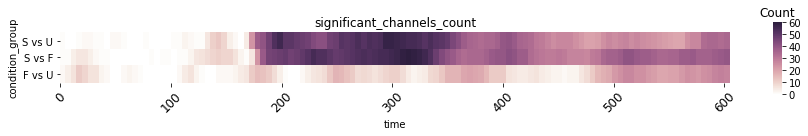

<Figure size 432x288 with 0 Axes>

In [7]:
script = {'conditions': 'S vs U:Scrambled&Unfamiliar,S vs F:Scrambled&Famous,F vs U:Famous&Unfamiliar',
          'timepoints': '0~600'}
e = epoch.extract(script)

sig_ch_count = e.significant_channels_count(win_size='5ms')
sig_ch_count.save('DATAS/EasyEEG_paper/sig_ch_count')
sig_ch_count.plot()


### Topographic differences
- Define the wanted data in a dictionary
- Extract the neede data snippet
- Calculate the topographic differences
- Save the calculated result data into '.pickle' file
- Plot the result data

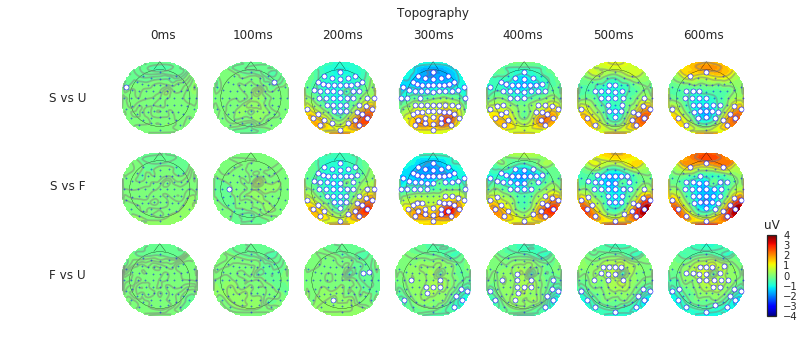

<Figure size 432x288 with 0 Axes>

In [9]:
script = {'conditions': 'S vs U:Scrambled&Unfamiliar,S vs F:Scrambled&Famous,F vs U:Famous&Unfamiliar',
          'timepoints': '-50~600'}
e = epoch.extract(script)

topo = e.topography(win_size='100ms')
topo.save('DATAS/EasyEEG_paper/topo')
topo.plot(plot_params=dict(zlim=(-4,4)))


Result demo

In [ ]:
topo

### GFP
- Define the wanted data in a dictionary
- Extract the neede data snippet
- Calculate the GFP result and significance in comparison
- Save the calculated result data into '.pickle' file
- Plot the result data

EasyEEG loaded.
EasyEEG loaded.


100% 30/30 [00:00<00:00, 254.56it/s]
100% 30/30 [00:00<00:00, 235.48it/s]
100% 30/30 [00:00<00:00, 245.75it/s]


Your file have been added ".pickle" as the extension name.
Result saved.


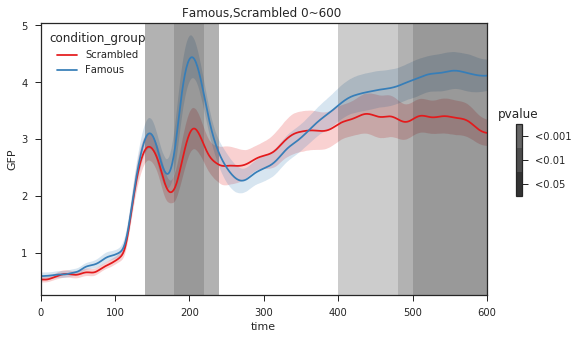

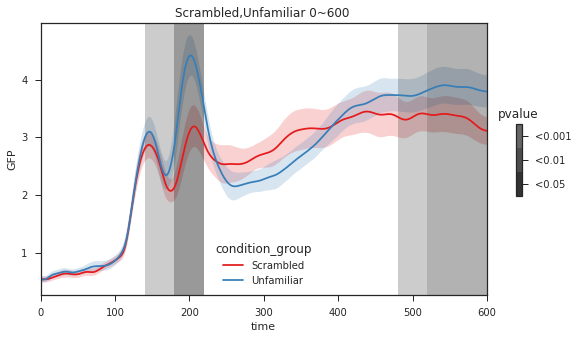

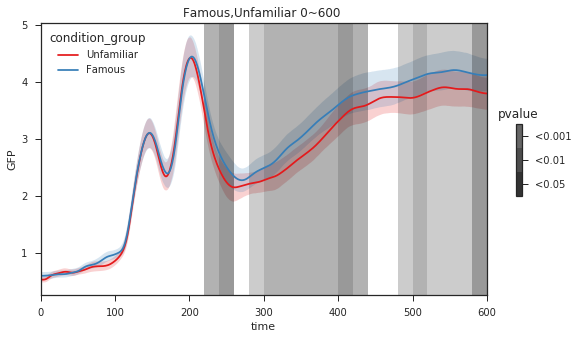

<Figure size 432x288 with 0 Axes>

In [9]:
scripts = [{'conditions': 'Scrambled,Famous',
                'timepoints': '0~600'},
           {'conditions': 'Scrambled,Unfamiliar',
                'timepoints': '0~600'},
           {'conditions': 'Unfamiliar,Famous',
                'timepoints': '0~600'}]

for idx,script in enumerate(scripts):
    e = epoch.extract(script)
    GFP = e.GFP(compare=True)
    GFP.default_plot_params['style']='ticks' # remove the backgroud color for paper publication
    GFP.save(f'DATAS/EasyEEG_paper/gfp{idx}')
    GFP.plot()

Result demo

In [ ]:
GFP

### TANOVA
- Define the wanted data in a dictionary
- Extract the neede data snippet
- Calculate the TANOVA in different strategies (1,2,3)
- Save the calculated result data into '.pickle' file
- Plot the result data after correcting the multiple comparison issue

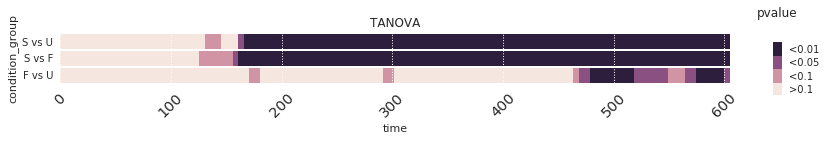

<Figure size 432x288 with 0 Axes>

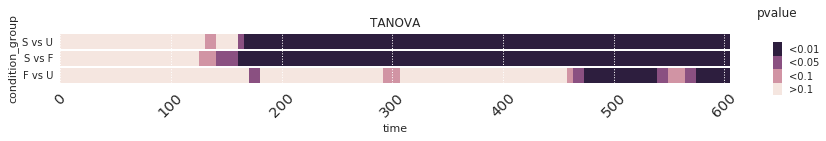

<Figure size 432x288 with 0 Axes>

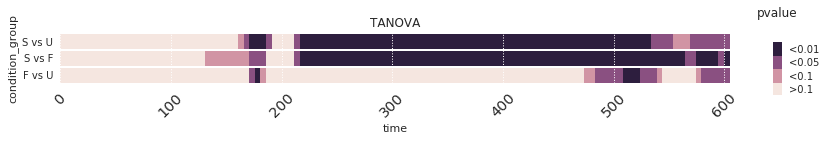

<Figure size 432x288 with 0 Axes>

In [11]:
script = {'conditions': 'S vs U:Scrambled&Unfamiliar,S vs F:Scrambled&Famous,F vs U:Famous&Unfamiliar',
          'timepoints': '0~600'}
e = epoch.extract(script)

t1 = e.tanova(win_size='5ms', shuffle=1000, strategy=1, parallel=True)
t2 = e.tanova(win_size='5ms', shuffle=1000, strategy=2, parallel=True)
t3 = e.tanova(win_size='5ms', shuffle=1000, strategy=3, parallel=True)

t1.save('DATAS/EasyEEG_paper/tanova_mode1')
t3.save('DATAS/EasyEEG_paper/tanova_mode3')
t2.save('DATAS/EasyEEG_paper/tanova_mode2')

t1.correct(method='cluster').plot()
t2.correct(method='cluster').plot()
t3.correct(method='cluster').plot()

Result demo

In [ ]:
t1

### Classification
- Define the wanted data in a dictionary
- Extract the neede data snippet
- Calculate the Classification result
- Save the calculated result data into '.pickle' file
- Plot the result data after correcting the multiple comparison issue

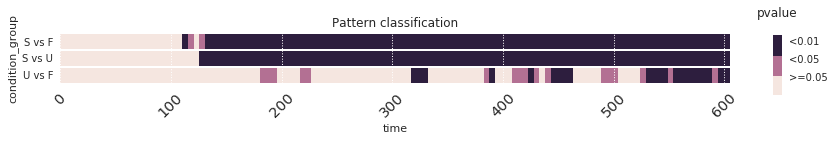

<Figure size 432x288 with 0 Axes>

In [12]:
script = {'conditions': 'S vs F:Scrambled&Famous,S vs U:Scrambled&Unfamiliar,U vs F:Unfamiliar&Famous',
          'timepoints': '0~600'}
e = epoch.extract(script)

c = e.classification(win_size='5ms',fold=25,parallel=False)
c.save('DATAS/EasyEEG_paper/classification')
c.correct(method='cluster').plot()

Result demo

In [ ]:
c